In [1]:
# Import pandas, numpy , matplot etc. libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt  
import pandas as pd
import math

# Import scikit learn packages
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

# Import Tensorflow packages
from tensorflow.keras.applications import MobileNet
import  tensorflow.keras.layers as L
import tensorflow as tf

## Prepare the training data

In [2]:
def  GenerateDataSet(frame, cnt, cow_count): 
    
    filename = str(cnt) +'.jpg'
    filenames.append(filename)
    count.append(cow_count)    

    file_name_path = r'Samples/' + str(cnt)+'.jpg'
    cv2.imwrite(file_name_path, frame) 
  
    cnt += 1

    if cnt == TOTAL_IMAGES:
        # Create a data frame: Cow counts corresponding to file name
        df = pd.DataFrame({'Filenames': filenames, 'Count':count})
        df.to_csv("Final.csv", index = False)
    return cnt

## Get the input data X 

In [3]:
img_width, img_height = 224,224
def format_image(path):
  img = cv2.imread(PATH + '/' + path)
  img = cv2.resize(img,(img_width,img_height))
  return img

In [4]:
PATH = 'Samples/'
paths = os.listdir(PATH)
#print(paths)
data = np.array([format_image(path) for path in paths])

## Get the labels

In [5]:
df = pd.read_csv('Final.csv')

label = df.Count
#label

## Split the training and testing data

In [6]:
x_train, x_test, y_train, y_test = train_test_split(data, label, test_size = 0.2, random_state = 10)


## Design the model

In [7]:
model = tf.keras.Sequential([
              MobileNet(input_shape=( img_width, img_height,3),
                        include_top=False,
                        pooling='avg',
                        weights='mobilenet_1_0_224_tf_no_top.h5'),
                         L.Dense(1, activation = 'relu')
                        ])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_224 (Function (None, 1024)              3228864   
_________________________________________________________________
dense (Dense)                (None, 1)                 1025      
Total params: 3,229,889
Trainable params: 3,208,001
Non-trainable params: 21,888
_________________________________________________________________


In [8]:
model.compile(optimizer='adam',loss='mae',metrics='mae')

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=5) #wait for 2 epochs, validation accuracy is not improving
# ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving 0.01 - 0.5*0.01 == 0.01/2
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)


callbacks = [earlystop, learning_rate_reduction]

## train the model

In [10]:
training = model.fit(
        x_train,
        y_train,
        batch_size=64,
        epochs=40,
        validation_data=(x_test,y_test),
        0callbacks = callbacks
         )

Epoch 1/40
7/7 [==============================] - 44s 6s/step - loss: 3.2315 - mae: 3.2315 - val_loss: 2.8524 - val_mae: 2.8524
Epoch 2/40
7/7 [==============================] - 46s 6s/step - loss: 1.6292 - mae: 1.6292 - val_loss: 1.0493 - val_mae: 1.0493
Epoch 3/40
7/7 [==============================] - 42s 6s/step - loss: 1.3258 - mae: 1.3258 - val_loss: 1.3690 - val_mae: 1.3690
Epoch 4/40
7/7 [==============================] - 42s 6s/step - loss: 1.1174 - mae: 1.1174 - val_loss: 2.6658 - val_mae: 2.6658
Epoch 5/40
7/7 [==============================] - 42s 6s/step - loss: 1.3128 - mae: 1.3128 - val_loss: 1.4796 - val_mae: 1.4796
Epoch 6/40
7/7 [==============================] - 43s 6s/step - loss: 0.7181 - mae: 0.7181 - val_loss: 0.9035 - val_mae: 0.9035
Epoch 7/40
7/7 [==============================] - 42s 6s/step - loss: 0.6400 - mae: 0.6400 - val_loss: 1.1933 - val_mae: 1.1933
Epoch 8/40
7/7 [==============================] - 42s 6s/step - loss: 0.4573 - mae: 0.4573 - val_loss: 1

## Evaluate the model
### As seen from the 100 epochs graph, after 40 epochs the loss is almost stable. To avoid overfitting, train the model with 40 epochs. 

In [11]:
y_pred = model.predict(x_test)

dict_keys(['loss', 'mae', 'val_loss', 'val_mae', 'lr'])


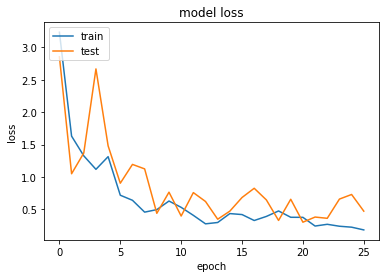

In [12]:
# list all data in training
print(training.history.keys())

# summarize traning for loss
plt.plot(training.history['loss'])
plt.plot(training.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Prediction

In [13]:
def Prediction(frame):
    cnt = 1
    img_width, img_height = 224, 224
    file_name_path = r'test/'+str(cnt) + '.jpg'
    cv2.imwrite(file_name_path, frame) 

    test_pic = cv2.imread(file_name_path)
    test_pic = cv2.resize(test_pic,(img_width, img_height))
    test_pic = test_pic.reshape(1,img_width, img_height,3)
    pred = model.predict(test_pic)
  
    return (math.floor(pred))

In [14]:
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('saved_model.h5')